In [1]:
import numpy as np
from scipy.special import erf
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
rng = np.random.default_rng()

In [2]:
N_Aiv, N_HVC, N_I = 500, 9, 125
conn_prob = 1

In [3]:
peak_rate, kernel_width = 100, 5

In [4]:
T_rend = 500 # Each rendition
N_rend = 15 # Number of renditions
T = N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(N_HVC, N_Aiv))
# ( Number of syllables , Number of renditions )
tsyl_start = np.array([[T_rend * (j + i/(N_HVC+1)) for j in range(N_rend)]
                       for i in range(N_HVC)])
tsyl_end = tsyl_start + T_rend * 1/(N_HVC+1)
burst_ts = tsyl_start + T_rend * 0.5/(N_HVC+1)
save_W_ts = tsyl_end[-1]

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
aud = generate_discrete_aud(T, N_Aiv, tsyl_start.T.flatten(), tsyl_end.T.flatten(), 
                            np.tile(syl, (N_rend, 1)))

In [8]:
rmax, s, th = 100, 1, 5
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [9]:
def bilin_hebb(W, aiv, hvc, lr, w0_mean, tau_w):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * aiv * h - (W[:,i] - w0_mean) / tau_w
        W[:,i] = np.clip(W[:,i] + dW, a_min=0, a_max=None)

In [10]:
w0_mean, w0_std = 1/N_HVC, 0.5/N_HVC
JEE, JEI, JIE, JII = 1, 2, 1, 1
tau_Aiv, tau_I, dt = 10, 5, 1

net = AivWilsonCowan(N_Aiv, N_HVC, conn_prob, w0_mean, w0_std, phi, tau_Aiv,
                     N_I, tau_I, JEE, JEI, JIE, JII)

Aiv0, I0, ext_I = phi(rng.normal(0, 1, size=N_Aiv)), 5, 0

_ = net.sim(Aiv0, I0, rH, aud, save_W_ts, T, dt, 0.2, ext_I, bilin_hebb,
            lr=-1e-6, w0_mean=w0_mean, tau_w=1e6)
rA, rI, Ws, mean_HVC_input = _

(0.0, 1000.0)

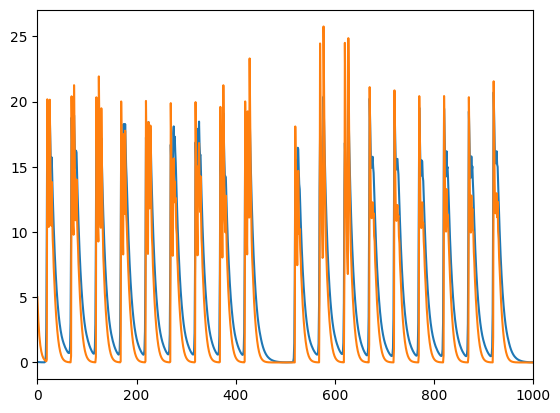

In [11]:
plt.plot(rA.mean(axis=1))
plt.plot(rI)
plt.xlim([0, 1000])

[Text(0.5, 0, 'Time (a.u.)'), Text(0, 0.5, 'mean input\nfrom HVC')]

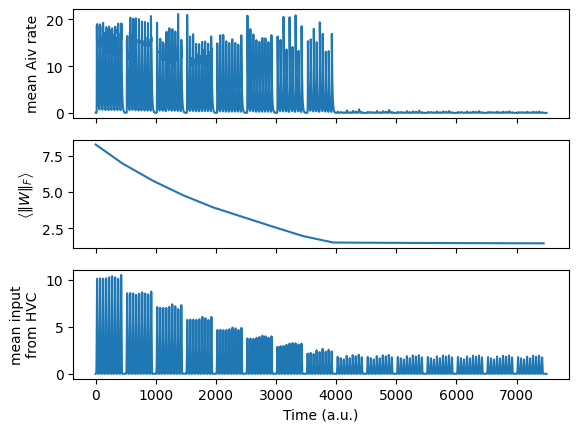

In [12]:
W_norms = np.array([np.linalg.norm(_, ord='fro') for _ in Ws]) # Frobenius norm
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rA.mean(axis=1))
ax[1].plot(np.hstack([[0], save_W_ts]), W_norms)
ax[2].plot(mean_HVC_input)
ax[0].set(ylabel='mean Aiv rate')
ax[1].set(ylabel=r'$\left\langle \| W \|_F \right\rangle$')
ax[2].set(xlabel='Time (a.u.)', ylabel='mean input\nfrom HVC')

In [13]:
W_syl_corrs = [correlation(_.T, syl, lambda x: x) for _ in Ws]

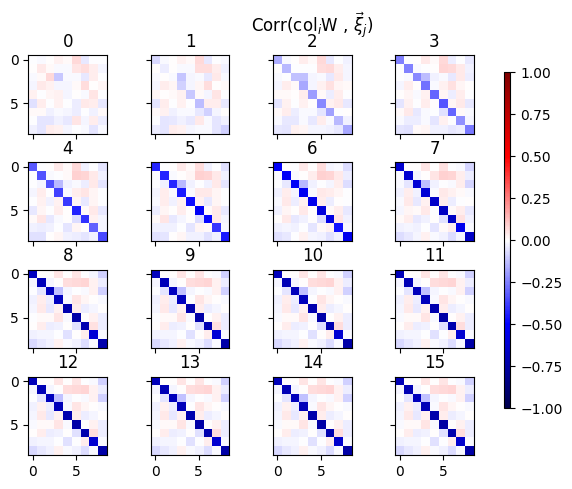

In [14]:
fig, ax = plt.subplots(4, 4, sharex='all', sharey='all')
ax = ax.flatten()
for i, wsc in enumerate(W_syl_corrs):
    im = ax[i].imshow(wsc, vmax=1, vmin=-1, cmap='seismic')
    ax[i].set_title(i)
fig.suptitle(r'Corr(col$_i$W , $\vec\xi_j$)')
fig.tight_layout(pad=0.1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

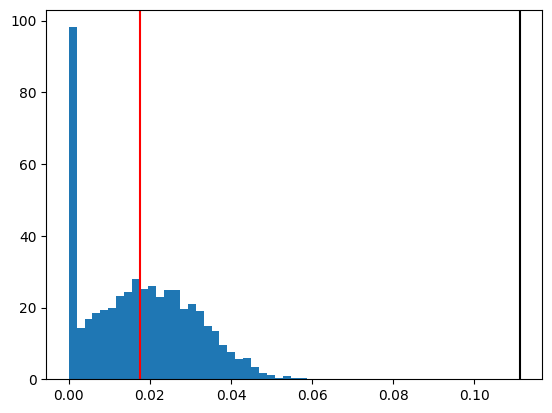

In [15]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

In [16]:
Aiv0, I0 = phi(rng.normal(0, 1, size=N_Aiv)), 5

noise = 0.2
idx_si = np.arange(syl.shape[0]) # shuffle index
syl_sp = syl.copy() # shuffle syllable patterns
rng.shuffle(idx_si, axis=0)
while (idx_si == np.arange(len(idx_si))).any():
    rng.shuffle(idx_si, axis=0)
# idx_si[1:5] = np.arange(1, 5)
rng.shuffle(syl_sp, axis=1)

aud_si = generate_discrete_aud(T_rend, N_Aiv, tsyl_start[:,0], tsyl_end[:,0], syl[idx_si])
aud_sp = generate_discrete_aud(T_rend, N_Aiv, tsyl_start[:,0], tsyl_end[:,0], syl_sp)

In [17]:
# plasticity function is None and lr is 0 by default
ext_I = 0
test0 = net.sim(Aiv0, I0, rH[:T_rend], aud[:T_rend], [], T_rend, dt, noise, ext_I)
test_si = net.sim(Aiv0, I0, rH[:T_rend], aud_si, [], T_rend, dt, noise, ext_I)
test_sp = net.sim(Aiv0, I0, rH[:T_rend], aud_sp, [], T_rend, dt, noise, ext_I)
test0, test_si, test_sp = test0[:2], test_si[:2], test_sp[:2] # just want rA and rI

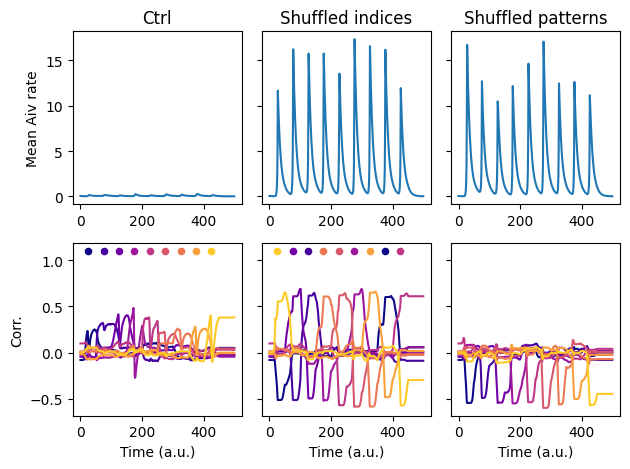

In [18]:
labels = ('Ctrl', 'Shuffled indices', 'Shuffled patterns')
cmap = colormaps.get_cmap('plasma')
fig, ax = plt.subplots(2, 3, sharey='row')
for i, (test, l) in enumerate(zip((test0, test_si, test_sp), labels)):
    corr = correlation(test[0], syl, lambda x: x)
    # ax[0,i].plot(test[1][:], test[0].mean(axis=1)[:], lw=1)
    ax[0,i].plot(test[0].mean(axis=1)[:])
    # ax[0,i].plot(test[1][:]) # rI is already the mean
    ax[0,i].set(title=l)
    ax[1,i].set(xlabel='Time (a.u.)')
    for j in range(corr.shape[1]):
        ax[1,i].plot(corr[:,j], c=cmap(j/corr.shape[1]))

for i, j in enumerate(idx_si):
    c1, c2 = cmap(i/len(idx_si)), cmap(j/len(idx_si))
    ax[1,0].scatter(burst_ts[i,0], 1.1, color=c1, s=20)
    ax[1,1].scatter(burst_ts[i,0], 1.1, color=c2, s=20)
ax[0,0].set(ylabel='Mean Aiv rate')
ax[1,0].set(ylabel='Corr.')
fig.tight_layout()

[(-5.0, 20.0), Text(0.5, 0, 'Input'), Text(0, 0.5, 'Rate')]

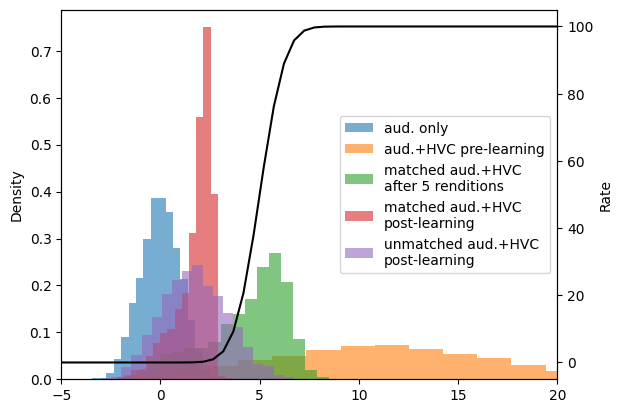

In [19]:
fig, ax = plt.subplots()
a = 0.6
ax = [ax, ax.twinx()]
ax[0].hist(syl.flatten(), bins=20, density=True, alpha=a, 
           label='aud. only')
ax[0].hist((syl+Ws[0].T*peak_rate).flatten(), bins=20, density=True, alpha=a,
           label='aud.+HVC pre-learning')
ax[0].hist((syl+Ws[5].T*peak_rate).flatten(), bins=20, density=True, alpha=a, 
           label='matched aud.+HVC\nafter 5 renditions')
ax[0].hist((syl+Ws[-1].T*peak_rate).flatten(), bins=20, density=True, alpha=a, 
           label='matched aud.+HVC\npost-learning')
ax[0].hist((syl[idx_si]+Ws[-1].T*peak_rate).flatten(), bins=20, density=True, 
           alpha=a, label='unmatched aud.+HVC\npost-learning')
_ = np.linspace(-5, 20)
ax[0].set(xlim=_[[0,-1]], ylabel='Density')
ax[0].legend(loc='right')
ax[1].plot(_, phi(_), c='k')
ax[1].set(xlim=_[[0,-1]], xlabel='Input', ylabel='Rate')